In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

import numpy as np
import pulse2percept as p2p 
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [27]:
model = BiphasicAxonMapModel(engine='cython', min_ax_sensitivity=1e-2, a4=0, xystep = 0.4)
model.build()
bundles = model.grow_axon_bundles()
axons = model.find_closest_axon(bundles)
axon_contrib = model.calc_axon_sensitivity(axons, pad=True).astype(np.float32)
implant = ArgusII()
x = np.array([implant.earray[e].x for e in implant.electrodes], dtype='float32')
y = np.array([implant.earray[e].y for e in implant.electrodes], dtype='float32')
rho=model.rho

In [28]:
def predict_freq_amp(amp, freq):
    """ Eq 4 in paper, A_2*A_tilde + A_3*f + A_4 """
    return 0.1492147*amp + 0.0163851*freq

def bright(freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value by which brightness contribution for each electrode should
    be scaled by (F_bright).
    Must support batching (freq, amp, pdur may be arrays)
    """
    # Scale amp according to pdur (Eq 3 in paper) and then calculate F_{bright}
    F_bright = predict_freq_amp(amp * scale_threshold(pdur), freq)
    return F_bright

def scale_threshold(pdur):
    """ 
    Based on eq 3 in paper, this function produces the factor that amplitude
    will be scaled by to produce a_tilde. Computes A_0 * t + A_1 (1/threshold)
    """
    return 0.054326 + 2.095*pdur

def size(freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value for each electrode that rho should be scaled by (F_size)
    Must support batching (freq, amp, pdur may be arrays)
    """
    min_f_size = 10**2 / 200**2
    F_size = 1.0812 * amp * scale_threshold(pdur) -0.35338
    return tf.maximum(F_size, min_f_size)

def streak( freq, amp, pdur):
    """
    Main function to be called by BiphasicAxonMapModel
    Outputs value for each electrode that lambda should be scaled by (F_streak)
    Must support batching (freq, amp, pdur may be arrays)
    """
    min_f_streak = 10**2 / 800 ** 2
    F_streak = 1.56 - 0.54 * pdur ** 0.21
    return tf.maximum(F_streak, min_f_streak)

In [29]:
@tf.function
def biphasic_axon_map_batched(elec_params, x, y, axon_segments, rho):
    bright_effects = bright(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    size_effects = size(elec_params[:, :, 0], 
                                  elec_params[:, :, 1], 
                                  elec_params[:, :, 2])
    streak_effects = streak(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=2)
    # print(eparams)

    d2_el = (axon_segments[:, :, 0, None] - x)**2 + (axon_segments[:, :, 1, None] - y)**2
    intensities = eparams[:, None, None, :, 0] * tf.math.exp(-d2_el[None, :, :, :] / (2. * rho**2 * eparams[:, :, 1])[:, None, None, :]) * (axon_segments[None, :, :, 2, None] ** (1./eparams[:, None, None, :, 2]))
    # return intensities
    return tf.reduce_max(tf.reduce_sum(intensities, axis=-1), axis=-1)

@tf.function
def biphasic_axon_map_single(elec_params, x, y, axon_segments, rho):
    bright_effects = bright(elec_params[ :, 0], 
                                      elec_params[:, 1], 
                                      elec_params[:, 2])
    size_effects = size(elec_params[:, 0], 
                                  elec_params[:, 1], 
                                  elec_params[:, 2])
    streak_effects = streak(elec_params[:, 0], 
                                      elec_params[:, 1], 
                                      elec_params[:, 2])
    eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=1)

    d2_el = (axon_segments[:, :, 0, None] - x)**2 + (axon_segments[:, :, 1, None] - y)**2
    intensities = eparams[:, 0] * tf.math.exp(-d2_el / (2. * rho**2 * eparams[:, 1])) * (axon_segments[:, :, 2, None] ** (1./eparams[:, 2]))
    resp = tf.math.reduce_max(tf.math.reduce_sum(intensities, axis=-1), axis=-1)
    return resp


# def predict_one_point_tf(axon, eparams, x, y, rho):
#     d2_el = (axon[:, :, 0, None] - x)**2 + (axon[:, :, 1, None] - y)**2
#     intensities = eparams[:, 0] * tf.math.exp(-d2_el / (2. * rho**2 * eparams[:, 1])) * (axon[:, 2, None] ** (1./eparams[:, 2]))
#     return tf.math.reduce_max(tf.math.reduce_sum(intensities, axis=-1), axis=-1)

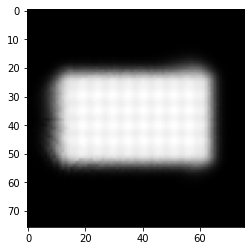

In [30]:
p = biphasic_axon_map_single(tf.ones((60, 3)), x, y, axon_contrib, rho)
p.shape
plt.imshow(np.array(p).reshape(76, 76), cmap='gray')

In [39]:
%time p = biphasic_axon_map_single(tf.ones((4, 3)), x[:4], y[:4], axon_contrib, rho)

CPU times: user 2.18 ms, sys: 7.17 ms, total: 9.35 ms
Wall time: 8.15 ms


In [40]:
%time p = biphasic_axon_map_single(tf.ones((5, 3)), x[:5], y[:5], axon_contrib, rho)

CPU times: user 70.4 ms, sys: 635 µs, total: 71 ms
Wall time: 68.8 ms


In [ ]:
a = biphasic_axon_map_batched(tf.ones((16, 15, 3)), x[:15], y[:15], axon_contrib, rho)

In [8]:
%time biphasic_axon_map_batched(tf.ones((64, 60, 3)), x, y, axon_contrib, rho)

CPU times: user 2.44 ms, sys: 1.64 ms, total: 4.07 ms
Wall time: 3.19 ms


<tf.Tensor: shape=(64, 5776), dtype=float32, numpy=
array([[8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       ...,
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16],
       [8.87e-26, 1.04e-25, ..., 3.90e-15, 9.52e-16]], dtype=float32)>

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

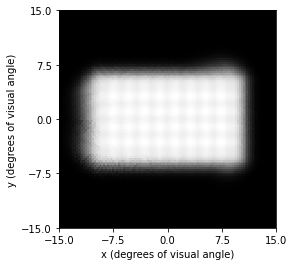

In [42]:
stim = {e : BiphasicPulseTrain(1,1,1) for e in implant.electrodes}
implant.stim = stim
p1 = model.predict_percept(implant)
p1.plot()

In [111]:
import tensorflow as tf
from keras import backend as K
import numpy as np
from skimage.transform import resize
%load_ext tensorboard
import pulse2percept as p2p
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.utils import center_image
from pulse2percept.implants import ArgusII


def get_loss(model, implant, regularize=None, reg_coef=0.05):
    bundles = model.grow_axon_bundles()
    axons = model.find_closest_axon(bundles)
    axon_contrib = model.calc_axon_sensitivity(axons, pad=True).astype(np.float32)
    axon_contrib = tf.constant(axon_contrib, dtype='float32')
    x = tf.constant([implant[e].x for e in implant.electrodes], dtype='float32')
    y = tf.constant([implant[e].y for e in implant.electrodes], dtype='float32')
    rho = model.rho
    # get effect models. Need to reimplement them in tensorflow fashion
    def scale_threshold(pdur):
        return model.a1 + model.a0*pdur
    def predict_freq_amp(amp, freq):
        return model.a2*amp + model.a3*freq
    def bright(freq, amp, pdur):
        F_bright = predict_freq_amp(amp * scale_threshold(pdur), freq)
        return F_bright
    def size(freq, amp, pdur):
        min_f_size = 10**2 / (model.rho**2)
        F_size = model.a5 * amp * model.scale_threshold(pdur) + model.a6
        return tf.maximum(F_size, min_f_size)
    def streak(freq, amp, pdur):
        min_f_streak = 10**2 / (model.axlambda ** 2)
        F_streak = model.a9 - model.a7 * pdur ** model.a8
        return tf.maximum(F_streak, min_f_streak)

    # def reg_none(y_pred):
    #     return tf.zeros((len(y_pred)))
    # def reg_l1(y_pred):
    #     return tf.reduce_sum(tf.abs(y_pred), axis=-1) 
    # def reg_l2(y_pred):
    #     return tf.reduce_mean(y_pred**2, axis=-1)
    # if regularize is None:
    #     reg = reg_none
    # elif regularize == 'l1':
    #     reg = reg_l1
    # elif regularize == 'l2':
    #     reg = reg_l2

    def biphasic_axon_map_batched(ypred):
        bright_effects = bright(ypred[:, :, 0], 
                                ypred[:, :, 1], 
                                ypred[:, :, 2])
        size_effects = size(ypred[:, :, 0], 
                            ypred[:, :, 1], 
                            ypred[:, :, 2])
        streak_effects = streak(ypred[:, :, 0], 
                                ypred[:, :, 1], 
                                ypred[:, :, 2])
        eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=2)
        d2_el = (axon_contrib[:, :, 0, None] - x)**2 + (axon_contrib[:, :, 1, None] - y)**2
        intensities = eparams[:, None, None, :, 0] * tf.math.exp(-d2_el[None, :, :, :] / (2. * rho**2 * eparams[:, :, 1])[:, None, None, :]) * (axon_contrib[None, :, :, 2, None] ** (1./eparams[:, None, None, :, 2]))
        return tf.reduce_max(tf.reduce_sum(intensities, axis=-1), axis=-1)
    # assumes model outputs same shape as ytrue
    def mse(ytrue, ypred):
        pred_imgs = biphasic_axon_map_batched(ypred)
        yt = tf.reshape(ytrue, pred_imgs.shape)
        return tf.reduce_mean((pred_imgs - yt)**2, axis=-1)
    
    return mse

In [ ]:
@tf.function
def biphasic_axon_map_batched(elec_params, x, y, axon_segments, rho):
    bright_effects = bright(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    size_effects = size(elec_params[:, :, 0], 
                                  elec_params[:, :, 1], 
                                  elec_params[:, :, 2])
    streak_effects = streak(elec_params[:, :, 0], 
                                      elec_params[:, :, 1], 
                                      elec_params[:, :, 2])
    eparams = tf.stack([bright_effects, size_effects, streak_effects], axis=2)
    # print(eparams)

    d2_el = (axon_segments[:, :, 0, None] - x)**2 + (axon_segments[:, :, 1, None] - y)**2
    intensities = eparams[:, None, None, :, 0] * tf.math.exp(-d2_el[None, :, :, :] / (2. * rho**2 * eparams[:, :, 1])[:, None, None, :]) * (axon_segments[None, :, :, 2, None] ** (1./eparams[:, None, None, :, 2]))
    # return intensities
    return tf.reduce_max(tf.reduce_sum(intensities, axis=-1), axis=-1)

In [112]:
lossfn = get_loss(model, implant)

In [113]:
stim = np.ones((2, 60, 3), dtype='float32')
# x = np.array([implant.earray[e].x for e in implant.electrodes], dtype='float32')
# y = np.array([implant.earray[e].y for e in implant.electrodes], dtype='float32')
stim_p2p = {e : BiphasicPulseTrain(1,1,1) for e in implant.electrodes}
implant.stim = stim_p2p
perc = model.predict_percept(implant)
pdata = np.array([perc.data[:, :, 0], perc.data[:, :, 0]], dtype='float32')


In [115]:
%timeit lossfn(pdata, stim)

4.13 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
import numpy as np
from skimage.transform import resize

import pulse2percept as p2p
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.utils import center_image
from pulse2percept.implants import ArgusII
from cs291a import *


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

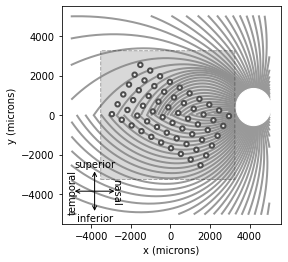

In [6]:
model = BiphasicAxonMapModel(rho=300, axlambda=800, a4=0, engine='cython', min_ax_sensitivity=1e-2, xystep = 0.4, xrange=(-13, 12), yrange=(-12, 12))
model.build()
implant = ArgusII(rot=-30)
model.plot()
implant.plot()

In [7]:
lossfn = get_loss(model, implant)
stim = np.ones((2, 60, 3), dtype='float32')
# x = np.array([implant.earray[e].x for e in implant.electrodes], dtype='float32')
# y = np.array([implant.earray[e].y for e in implant.electrodes], dtype='float32')
stim_p2p = {e : BiphasicPulseTrain(1,1,1) for e in implant.electrodes}
implant.stim = stim_p2p
perc = model.predict_percept(implant)
pdata = np.array([perc.data[:, :, 0], perc.data[:, :, 0]], dtype='float32')

NameError: name 'get_loss' is not defined

## Test running tensorflow model

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import keras 
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pulse2percept as p2p
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain
import shapes
import cs291a

import datetime

In [ ]:
model = BiphasicAxonMapModel(axlambda=800, rho=200, a4=0, engine="jax", xystep=0.5, xrange=(-14, 12), yrange=(-12, 12))
model.build()
implant = ArgusII(rot=-30)
ex = np.array([implant[e].x for e in implant.electrodes], dtype='float32')
ey = np.array([implant[e].y for e in implant.electrodes], dtype='float32')

targets, stims = cs291a.read_h5("../data/percepts/percepts_argusii_1elec_rho200lam800_12031654.h5")
targets = targets.reshape((-1, 49, 53, 1))
nn = cs291a.get_model(implant, targets[0].shape, sigmoid=True)

In [3]:
nn(targets[0:1])


<tf.Tensor: shape=(1, 60, 3), dtype=float32, numpy=
array([[[0.04, 0.05, 0.  ],
        [0.05, 0.01, 0.  ],
        ...,
        [0.  , 0.03, 0.03],
        [0.04, 0.  , 0.02]]], dtype=float32)>

In [7]:
i1 = tf.ones((60, 3))
i2 = tf.zeros((60))
i1 * i2[:, None]

<tf.Tensor: shape=(60, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

In [10]:
targets_train, targets_test, stims_train, stims_test = train_test_split(targets, stims, test_size=0.2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lossfn = cs291a.get_loss(model, implant, regularize=None, reg_coef=0.005)
# es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss')
log_dir = "../results/tensorboard/"+ datetime.datetime.now().strftime("%m%d-%H%M%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
nn.compile(optimizer=optimizer, loss=lossfn, metrics=[lossfn])

In [ ]:
cs291a.train_model(nn, model, implant, None, targets, stims, 0, 'percepts', 'adam', 0.0001)

In [11]:
lossfn(targets[0:1], stims[0:1]) 

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [ ]:
hist = nn.fit(x=targets_train, y=targets_train, batch_size=32, epochs=1,  callbacks=[tb])#validation_data=(targets_test, targets_test), validation_batch_size=32)

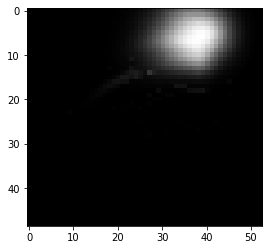

In [40]:
plt.imshow(model._predict_spatial_jax(nn(targets_train[3:4]).numpy()[0], ex, ey).reshape(model.grid.shape), cmap='gray')

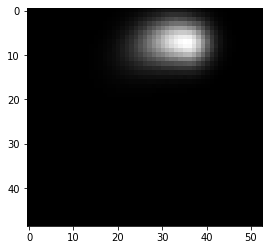

In [41]:
plt.imshow(targets_train[3].reshape(model.grid.shape), cmap='gray')

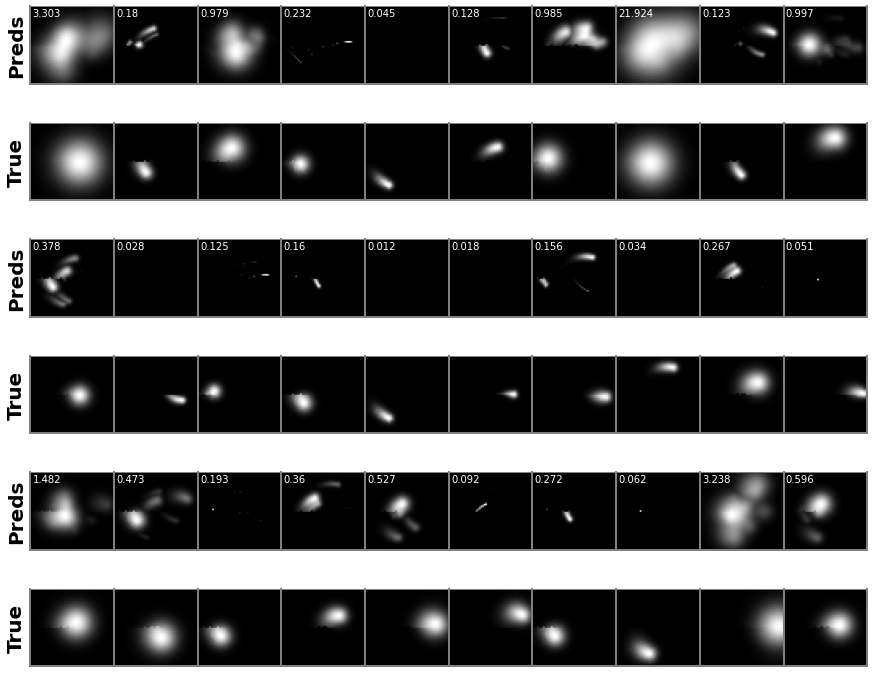

In [6]:
ims_per_row = 10
rows = 3
fig, axes = plt.subplots(nrows = rows*2, ncols=ims_per_row, figsize=(15, 15))
fig.subplots_adjust(wspace=0, hspace=-0.5)
# predicted first
for i in range(rows):
    for j in range(ims_per_row):
        if j == 1:
            plt.ylabel("Preds", fontweight="bold", fontsize=20)
        plt.sca(axes[2*i][j])
        idx = i * ims_per_row + j
        pred = nn(targets_test[idx:idx+1]).numpy()
        score = float(lossfn(targets_test[idx:idx+1], pred).numpy())
        pred_img = model._predict_spatial_jax(pred[0], ex, ey)
        plt.imshow(pred_img.reshape(model.grid.shape), cmap='gray')
        plt.annotate(f"{str(round(score, 3))}", (1, 6), color='white')
        plt.yticks([])
        plt.xticks([])
        axes[2*i][j].spines['bottom'].set_color('gray')
        axes[2*i][j].spines['top'].set_color('gray')
        axes[2*i][j].spines['right'].set_color('gray')
        axes[2*i][j].spines['left'].set_color('gray')
        axes[2*i][j].spines['bottom'].set_linewidth(2)
        axes[2*i][j].spines['top'].set_linewidth(1)
        axes[2*i][j].spines['right'].set_linewidth(2)
        axes[2*i][j].spines['left'].set_linewidth(2)
        # plt.axis(False)
for i in range(rows):
    for j in range(ims_per_row):
        if j == 1:
            plt.ylabel("True", fontweight="bold", fontsize=20)
        plt.sca(axes[2*i+1][j])
        idx = i * ims_per_row + j
        plt.imshow(targets_test[idx], cmap='gray')
        # plt.axis(False)
        plt.yticks([])
        plt.xticks([])
        axes[2*i+1][j].spines['bottom'].set_color('gray')
        axes[2*i+1][j].spines['top'].set_color('gray')
        axes[2*i+1][j].spines['right'].set_color('gray')
        axes[2*i+1][j].spines['left'].set_color('gray')
        axes[2*i+1][j].spines['bottom'].set_linewidth(2)
        axes[2*i+1][j].spines['top'].set_linewidth(1)
        axes[2*i+1][j].spines['right'].set_linewidth(2)
        axes[2*i+1][j].spines['left'].set_linewidth(2)
# fig.tight_layout()
plt.show()
        

In [ ]:
import matplotlib.pyplot as plt

In [38]:
str(None)

'None'

In [7]:
red = nn(targets_test[0:0+1]).numpy()

In [8]:
red[red[:, :, 1] > 0.5]

array([[0.00e+00, 7.74e-01, 1.00e-03],
       [0.00e+00, 8.44e-01, 1.00e-03],
       [0.00e+00, 5.37e-01, 1.00e-03],
       [0.00e+00, 1.07e+00, 1.22e+00]], dtype=float32)

In [86]:
np.max(red[:, :, 1])

0.08294555

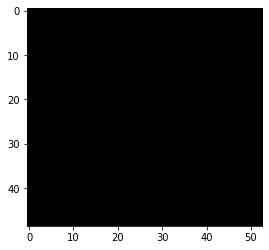

In [13]:
plt.imshow(model._predict_spatial_jax(stim, ex, ey).reshape(model.grid.shape), cmap='gray')

In [12]:
stim = np.zeros((60, 3), dtype='float32')
stim[7] = [20, 0.4, 0.45]


In [92]:
import importlib

In [94]:
importlib.reload()

NameError: name 'matplotlib' is not defined

In [16]:
tf.math.count_nonzero(tf.constant([[True, False, False], [False, False, False]]), axis=-1)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [1]:
import json
info = json.load(open("../results/percepts/info.json"))

In [3]:
info = info['1elec']

In [9]:
k = min([i for i in info.keys() if 'size_norm' not in info[i].keys() or info[i]['size_norm'] == False], key = lambda x : info[x]['test_loss'])
info[k]

{'test_loss': 0.04137365520000458,
 'train_loss': 0.04137365520000458,
 'epochs': 500,
 'opt': 'adam',
 'lr': 0.0001,
 'reg': None,
 'reg_coef': 0.0005,
 'batch_size': 32,
 'dense_layers': 1,
 'tensorboard_logdir': '../results/tensorboard/nn_60elecs_adam_lr0.0001_None_1204-105645_1204-105645',
 'rho': 200,
 'lambda': 800,
 'n_elecs': 1,
 'shape': '(49, 53)',
 'force_good_stims': 'False'}

## Alphabet

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# import tensorflow as tf
# import keras 
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pulse2percept as p2p
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.implants import ArgusII
from pulse2percept.stimuli import BiphasicPulseTrain
import shapes
import cs291a

import datetime

In [5]:
model = BiphasicAxonMapModel(axlambda=800, rho=200, a4=0, engine="jax", xystep=0.5, xrange=(-14, 12), yrange=(-12, 12))
model.build()
implant = ArgusII(rot=-30)
ex = np.array([implant[e].x for e in implant.electrodes], dtype='float32')
ey = np.array([implant[e].y for e in implant.electrodes], dtype='float32')
letters, labels = cs291a.load_alphabet("../data/alphabet", model)

In [6]:
np.mean(letters)

0.5905886

In [7]:
targets = letters.reshape((-1, 49, 53, 1))

In [5]:
nn = cs291a.get_model(implant, targets[0].shape, num_dense=1, clip='relu')
lossfn = cs291a.get_loss(model, implant, regularize=None, reg_coef=0.0, size_norm=False)

In [8]:
targets_train, targets_test, labels_train, labels_test = train_test_split(targets, labels, test_size=0.2)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
nn.compile(optimizer=optimizer, loss=lossfn, metrics=[lossfn])

In [16]:
nn(targets_train[0:1]).numpy()

array([[[0.00e+00, 0.00e+00, 1.25e+00],
        [5.03e-01, 2.35e-02, 1.00e-03],
        ...,
        [0.00e+00, 8.45e-01, 1.00e-03],
        [2.41e+00, 2.94e+00, 1.97e+00]]], dtype=float32)

In [17]:
hist = nn.fit(x=targets_train, y=targets_train, batch_size=32, epochs=10)#validation_data=(targets_test, targets_test), validation_batch_size=32)

Epoch 1/10
51/51 [==============================] - 7s 94ms/step - loss: 0.6503 - loss_None: 0.6503
Epoch 2/10
51/51 [==============================] - 4s 70ms/step - loss: 0.5309 - loss_None: 0.5309
Epoch 3/10
51/51 [==============================] - 4s 70ms/step - loss: 0.4879 - loss_None: 0.4879
Epoch 4/10
51/51 [==============================] - 4s 70ms/step - loss: 0.4667 - loss_None: 0.4667
Epoch 5/10
51/51 [==============================] - 4s 70ms/step - loss: 0.4590 - loss_None: 0.4590
Epoch 6/10
51/51 [==============================] - 4s 71ms/step - loss: 0.4505 - loss_None: 0.4505
Epoch 7/10
51/51 [==============================] - 4s 71ms/step - loss: 0.4429 - loss_None: 0.4429
Epoch 8/10
51/51 [==============================] - 4s 71ms/step - loss: 0.4382 - loss_None: 0.4382
Epoch 9/10
51/51 [==============================] - 4s 72ms/step - loss: 0.4334 - loss_None: 0.4334
Epoch 10/10
51/51 [==============================] - 4s 73ms/step - loss: 0.4301 - loss_None: 0.4301

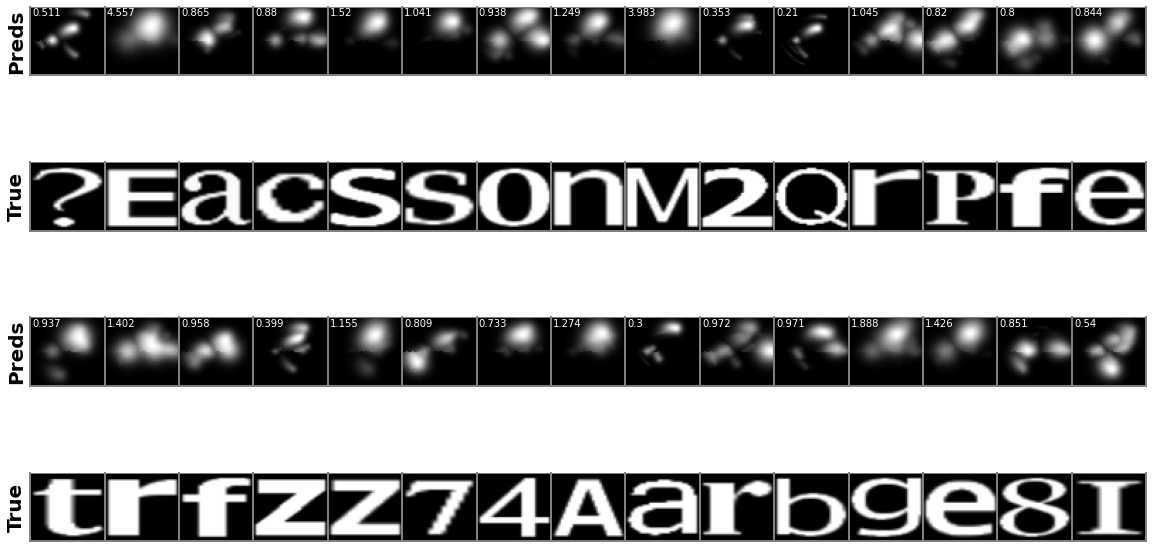

In [8]:
ims_per_row = 15
rows = 2
fig, axes = plt.subplots(nrows = rows*2, ncols=ims_per_row, figsize=(20, 20))
fig.subplots_adjust(wspace=0, hspace=-0.75)
# predicted first
for i in range(rows):
    for j in range(ims_per_row):
        if j == 1:
            plt.ylabel("Preds", fontweight="bold", fontsize=20)
        plt.sca(axes[2*i][j])
        idx = i * ims_per_row + j
        pred = nn(targets_train[idx:idx+1]).numpy()
        score = float(lossfn(targets_train[idx:idx+1], pred).numpy())
        pred_img = model._predict_spatial_jax(pred[0], ex, ey)
        plt.imshow(pred_img.reshape(model.grid.shape), cmap='gray')
        plt.annotate(f"{str(round(score, 3))}", (1, 6), color='white')
        plt.yticks([])
        plt.xticks([])
        axes[2*i][j].spines['bottom'].set_color('gray')
        axes[2*i][j].spines['top'].set_color('gray')
        axes[2*i][j].spines['right'].set_color('gray')
        axes[2*i][j].spines['left'].set_color('gray')
        axes[2*i][j].spines['bottom'].set_linewidth(2)
        axes[2*i][j].spines['top'].set_linewidth(1)
        axes[2*i][j].spines['right'].set_linewidth(2)
        axes[2*i][j].spines['left'].set_linewidth(2)
        # plt.axis(False)
for i in range(rows):
    for j in range(ims_per_row):
        if j == 1:
            plt.ylabel("True", fontweight="bold", fontsize=20)
        plt.sca(axes[2*i+1][j])
        idx = i * ims_per_row + j
        plt.imshow(targets_train[idx], cmap='gray')
        # plt.axis(False)
        plt.yticks([])
        plt.xticks([])
        axes[2*i+1][j].spines['bottom'].set_color('gray')
        axes[2*i+1][j].spines['top'].set_color('gray')
        axes[2*i+1][j].spines['right'].set_color('gray')
        axes[2*i+1][j].spines['left'].set_color('gray')
        axes[2*i+1][j].spines['bottom'].set_linewidth(2)
        axes[2*i+1][j].spines['top'].set_linewidth(1)
        axes[2*i+1][j].spines['right'].set_linewidth(2)
        axes[2*i+1][j].spines['left'].set_linewidth(2)

In [8]:
labels_train[11]

35

In [3]:
import imageio

In [9]:
len(letters)

2033

In [11]:
np.max(nn(targets_train[idx:idx+1]).numpy())

0.016603086

In [12]:
np.max(targets_train[idx:idx+1])

0.007843138

In [4]:
im = imageio.imread("../data/alphabet/2/2.png")

In [5]:
(im / 255 * 2).max() 

2.0

In [7]:
import skimage
skimage.transform.resize(im, model.grid.shape, anti_aliasing=True).max()

1.0

In [7]:
import json
info = json.load(open("../results/alphabet/info.json"))

In [8]:
info = info['1elec']

In [10]:
# sigmoid
{k:v for k, v in info.items() if v['opt'] == 'adam' and v['lr'] == 0.0001 and v['size_norm']=='False' and v['reg'] is None and v['dense_layers'] == 1}

{'nn_size_60elecs_adam_lr0.0001_None_1205-043316': {'test_loss': 0.42581549286842346,
  'train_loss': 0.4168945252895355,
  'epochs': 85,
  'opt': 'adam',
  'lr': 0.0001,
  'reg': None,
  'reg_coef': 0.0,
  'batch_size': 32,
  'dense_layers': 1,
  'tensorboard_logdir': '../results/tensorboard/alphabet/nn_size_60elecs_adam_lr0.0001_None_1205-043316',
  'rho': 200,
  'lambda': 800,
  'n_elecs': 1,
  'shape': '(49, 53)',
  'force_good_stims': 'False',
  'sigmoid': 'True',
  'size_norm': 'False'},
 'nn_size_60elecs_adam_lr0.0001_None_1205-045516': {'test_loss': 0.4243052005767822,
  'train_loss': 0.4120200276374817,
  'epochs': 84,
  'opt': 'adam',
  'lr': 0.0001,
  'reg': None,
  'reg_coef': 0.005,
  'batch_size': 32,
  'dense_layers': 1,
  'tensorboard_logdir': '../results/tensorboard/alphabet/nn_size_60elecs_adam_lr0.0001_None_1205-045516',
  'rho': 200,
  'lambda': 800,
  'n_elecs': 1,
  'shape': '(49, 53)',
  'force_good_stims': 'False',
  'sigmoid': 'False',
  'size_norm': 'False'},


In [6]:
{k:v for k, v in info.items() if v['opt'] == 'adam' and v['reg'] == None and v['size_norm']=='False' and v['dense_layers'] == 1 and v['sigmoid'] == 'False'}

{'nn_size_60elecs_adam_lr0.0001_None_1205-045516': {'test_loss': 0.4243052005767822,
  'train_loss': 0.4120200276374817,
  'epochs': 84,
  'opt': 'adam',
  'lr': 0.0001,
  'reg': None,
  'reg_coef': 0.005,
  'batch_size': 32,
  'dense_layers': 1,
  'tensorboard_logdir': '../results/tensorboard/alphabet/nn_size_60elecs_adam_lr0.0001_None_1205-045516',
  'rho': 200,
  'lambda': 800,
  'n_elecs': 1,
  'shape': '(49, 53)',
  'force_good_stims': 'False',
  'sigmoid': 'False',
  'size_norm': 'False'}}

In [11]:
{k:v for k, v in info.items() if v['opt'] == 'adam' and v['reg'] == None and v['size_norm']=='False' and v['dense_layers'] == 1 and v['sigmoid'] == 'False' and 'clip' in v.keys()}

{'nn__60elecs_adam_lr0.0001_None_coef0.051205-225343': {'test_loss': 0.41495466232299805,
  'train_loss': 0.37568163871765137,
  'epochs': 81,
  'opt': 'adam',
  'lr': 0.0001,
  'reg': None,
  'reg_coef': 0.05,
  'batch_size': 32,
  'dense_layers': 1,
  'tensorboard_logdir': '../results/tensorboard/alphabet/nn__60elecs_adam_lr0.0001_None_coef0.051205-225343',
  'rho': 200,
  'lambda': 800,
  'n_elecs': 1,
  'shape': '(49, 53)',
  'force_good_stims': 'False',
  'sigmoid': 'False',
  'size_norm': 'False',
  'clip': 'relu'},
 'nn__60elecs_adam_lr0.0001_None_coef0.051205-230049': {'test_loss': 0.9905467629432678,
  'train_loss': 0.9714276790618896,
  'epochs': 296,
  'opt': 'adam',
  'lr': 0.0001,
  'reg': None,
  'reg_coef': 0.05,
  'batch_size': 32,
  'dense_layers': 1,
  'tensorboard_logdir': '../results/tensorboard/alphabet/nn__60elecs_adam_lr0.0001_None_coef0.051205-230049',
  'rho': 200,
  'lambda': 800,
  'n_elecs': 1,
  'shape': '(49, 53)',
  'force_good_stims': 'False',
  'sigmoid

In [10]:
# fonts
sorted({k:v for k, v in info.items() if 'fonts' in v.keys()}, key = lambda x : info[x]['train_loss'])

['nn_28_60elecs_adam_lr0.0001_None_coef0.01206-013904',
 'nn_27_60elecs_adam_lr0.0001_None_coef0.01206-013502',
 'nn_26_60elecs_adam_lr0.0001_None_coef0.01206-013108',
 'nn_25_60elecs_adam_lr0.0001_None_coef0.01206-012711',
 'nn_29_60elecs_adam_lr0.0001_None_coef0.01206-014258',
 'nn_30_60elecs_adam_lr0.0001_None_coef0.01206-014656',
 'nn_21_60elecs_adam_lr0.0001_None_coef0.01206-011303',
 'nn_20_60elecs_adam_lr0.0001_None_coef0.01206-010857',
 'nn_10_60elecs_adam_lr0.0001_None_coef0.01206-002914',
 'nn_22_60elecs_adam_lr0.0001_None_coef0.01206-011708',
 'nn_17_60elecs_adam_lr0.0001_None_coef0.01206-005657',
 'nn_16_60elecs_adam_lr0.0001_None_coef0.01206-005259',
 'nn_15_60elecs_adam_lr0.0001_None_coef0.01206-004903',
 'nn_23_60elecs_adam_lr0.0001_None_coef0.01206-012059',
 'nn_8_60elecs_adam_lr0.0001_None_coef0.01206-002123',
 'nn_13_60elecs_adam_lr0.0001_None_coef0.01206-004101',
 'nn_1_60elecs_adam_lr0.0001_None_coef0.01205-235608',
 'nn_6_60elecs_adam_lr0.0001_None_coef0.01206-0014

In [1]:
import math

In [9]:
math.isclose(0)

False

In [14]:
implant=ArgusII(rot=-30)

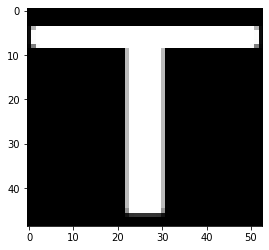

In [112]:
plt.imshow(np.minimum(letters[0],1), cmap='gray')

In [128]:
list(1 - tf.image.ssim_multiscale(letters[50:51]*5, letters[0:1], 10, power_factors = (0.1, 0.53, 0.23), filter_size=5).numpy())

[0.75895]

In [25]:
letters[0].shape

(49, 53, 1)

In [ ]:
letters = letters.reshape(-1, 49, 53, 1)

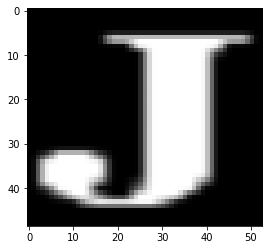

In [129]:
plt.imshow(letters[50], cmap='gray')

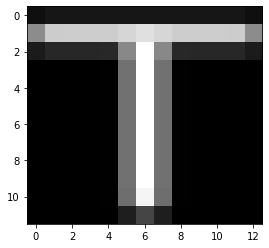

In [92]:
plt.imshow(skimage.transform.resize(letters[0], (12, 13, 1)), cmap='gray')

In [89]:
import skimage

In [5]:
nn = cs291a.get_model(implant, targets[0].shape, num_dense=1)

In [6]:
lossfn = cs291a.get_loss(model, implant, loss_fn='msssim')

In [7]:
pred = nn(targets[0:1])

In [8]:
lossfn(targets[0:1], pred)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.55], dtype=float32)>

In [12]:
img = model._predict_spatial_jax(pred[0].numpy(), ex, ey)

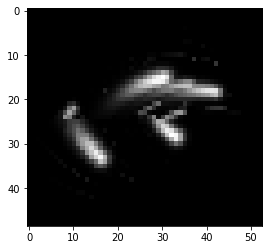

In [14]:
plt.imshow(img.reshape(model.grid.shape), cmap='gray')

In [44]:
1 - tf.image.ssim_multiscale(targets[0:1], img.reshape(1, 49, 53, 1), 3, power_factors = (0.0448, 0.2856, 0.3001, 0.2363), filter_size=7)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.94], dtype=float32)>

In [103]:
tf.image.psnr(targets[0:1], img.reshape(1, 49, 53, 1), 2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.62], dtype=float32)>

In [102]:
tf.image.psnr(targets[0:1], targets[2:3], 2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.9], dtype=float32)>

In [98]:
tf.image.psnr(targets[0:1], targets[0:1], 3)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([inf], dtype=float32)>

In [51]:
1 - tf.image.ssim(targets[0:1], img.reshape(1, 49, 53, 1), 3, filter_size=5, filter_sigma=2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.48], dtype=float32)>

In [52]:
1 - tf.image.ssim(targets[0:1], targets[2:3], 3, filter_size=5, filter_sigma=2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.43], dtype=float32)>

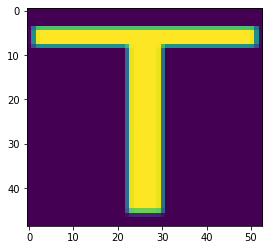

In [17]:
plt.imshow(targets[0])

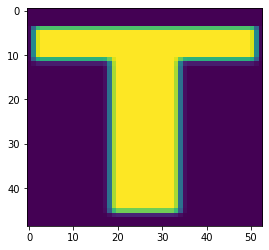

In [21]:
plt.imshow(targets[2])

In [56]:
def loss_test(ytrue, ypred):
    return 1 - tf.image.ssim_multiscale(ytrue, ypred, 3, power_factors = (0.0448, 0.2856, 0.3001, 0.2363), filter_size=7)

In [57]:
t = tf.function(loss_test)

In [59]:
t(targets[0:1], targets[2:3])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.36], dtype=float32)>

In [ ]:
a = tf.Variable(targets[0:1])
b = tf.Variable(targets[2:3])
c = tf.Variable(img.reshape(1, 49, 53, 1))
for idx in range(len(targets)-1):
    a = tf.Variable(targets[idx : idx+1])
    b = nn(targets[idx : idx+1])
    c = tf.Variable(model._predict_spatial_jax(b[0].numpy(), ex, ey).reshape((1, 49, 53, 1)))
    with tf.GradientTape() as tape:
        y = 1 - tf.image.ssim_multiscale(a, c, 3, power_factors = (0.0448, 0.2856, 0.3001, 0.2363), filter_size=7)

    tmp = tape.gradient(y, c)
    # print(tmp.numpy().mean(), end=' ')
    print(np.isnan(tmp.numpy().mean()), end=' ')
    if np.isnan(tmp.numpy().mean()):
        print("found one")

In [118]:
nn = cs291a.get_model(implant, targets[0].shape, num_dense=1, force_zero=False)
opt = tf.keras.optimizers.SGD(learning_rate=0.00000000001)
nn.compile(optimizer=opt, loss=lossfn)

In [ ]:
 hist = nn.fit(x=targets_train, y=targets_train, batch_size=32, epochs=10, validation_data=(targets_test, targets_test), validation_batch_size=32)

In [75]:
x = nn.layers[0](targets[0:1])

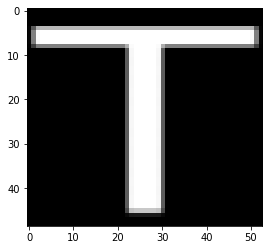

In [7]:
plt.imshow(targets[0], cmap='gray')

In [19]:
def encode(target, implant, model, mode='amp', stimrange=(0, 2), maxval=None):
    stim = []
    if maxval is None:
        maxval = np.max(target)
    for elec in implant.electrodes:
        # find location to sample
        x_dva, y_dva = model.retinotopy.ret2dva(implant.electrodes[elec].x, implant.electrodes[elec].y)
        # interpolate?
        # print(x_dva, y_dva)
        x_img = (x_dva - model.xrange[0]) / model.xystep
        y_img = (y_dva - model.yrange[0]) / model.xystep
        
        x_img = int(round(x_img, ndigits=0))
        y_img = int(round(y_img, ndigits=0))
        # image is centered differently
        # print(x_img, y_img)
        # print()
        px_intensity = target[y_img, x_img, 0]
        stim_intensity = px_intensity / maxval * (stimrange[1] - stimrange[0]) + stimrange[0]
        if stim_intensity < 0.5:
            stim_intensity = 0
            freq = 0
        else:
            freq = 20
        pulse = np.array([freq, stim_intensity, 0.45], dtype='float32')
        stim.append(pulse)
    return np.array(stim, dtype='float32')
        

In [11]:
import json
info = json.load(open("../results/alphabet/info.json"))['1elec']

In [18]:
def mse(true_img, pred, model, ex, ey, reg=None):
    pred_img = model._predict_spatial_jax(pred, ex, ey).reshape(model.grid.shape)
    true_img = true_img.reshape(model.grid.shape)
    ret = np.mean((true_img - pred_img)**2)
    if reg is None:
        return ret
    elif reg == 'l1':
        return ret + np.sum(np.abs(pred[:, 1]))
    elif reg == 'l2':
        return ret + np.sum(pred[:, 1]**2)
    elif reg == 'l1_ampfreq':
        return ret + np.sum(np.abs(pred[:, 0:1]))
    elif reg == 'elecs':
        return float(np.count_nonzero(pred[:, 1] > 0.5))

In [28]:
model = BiphasicAxonMapModel(axlambda=800, rho=200, a4=0, engine="jax", xystep=0.5, xrange=(-14, 12), yrange=(-12, 12))
model.build()
implant = ArgusII(rot=-30)
ex = np.array([implant[e].x for e in implant.electrodes], dtype='float32')
ey = np.array([implant[e].y for e in implant.electrodes], dtype='float32')
conventional_mses = {}
fonts = [[i] for i in range(1, 31)]
fonts.append([i for i in range(1, 31)])
regs = [None, 'l1', 'l2', 'l1_ampfreq', 'elecs']
for font in fonts:
    letters, labels = cs291a.load_alphabet("../data/alphabet", model, fonts=font)
    targets = letters.reshape((-1, 49, 53, 1))
    for reg in regs:
        mses = []
        for target_img in targets:
            encoding = encode(target_img, implant, model, maxval=2)
            mses.append(mse(target_img, encoding, model, ex, ey, reg=reg))
        mean_mse = np.mean(mses)
        if len(font) == 1:
            fontstr = str(font[0])
        else:
            fontstr = 'all'
        if fontstr not in conventional_mses.keys():
            conventional_mses[fontstr] = {}
        conventional_mses[fontstr][str(reg)] = float(mean_mse)
        
conventional_mses

{'1': {'None': 0.7388550043106079,
  'l1': 38.981788635253906,
  'l2': 69.38285827636719,
  'l1_ampfreq': 459.8565368652344,
  'elecs': 22.955882352941178},
 '2': {'None': 0.744099497795105,
  'l1': 39.59225845336914,
  'l2': 70.89682006835938,
  'l1_ampfreq': 462.23663330078125,
  'elecs': 23.074626865671643},
 '3': {'None': 1.081526279449463,
  'l1': 69.11833953857422,
  'l2': 130.74038696289062,
  'l1_ampfreq': 742.5520629882812,
  'elecs': 37.0735294117647},
 '4': {'None': 0.7417100667953491,
  'l1': 40.2867431640625,
  'l2': 72.23063659667969,
  'l1_ampfreq': 468.6205139160156,
  'elecs': 23.393939393939394},
 '5': {'None': 0.7402828335762024,
  'l1': 39.61534881591797,
  'l2': 70.17357635498047,
  'l1_ampfreq': 469.85791015625,
  'elecs': 23.455882352941178},
 '6': {'None': 0.726577877998352,
  'l1': 37.96212387084961,
  'l2': 67.28483581542969,
  'l1_ampfreq': 447.99932861328125,
  'elecs': 22.363636363636363},
 '7': {'None': 0.9924061894416809,
  'l1': 60.015960693359375,
  'l2

In [30]:
len(letters)

2033

In [29]:
json.dump(conventional_mses, open("../results/alphabet/conventional.json", 'w'))

In [ ]:
epochs = [i for i in range(1200)

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

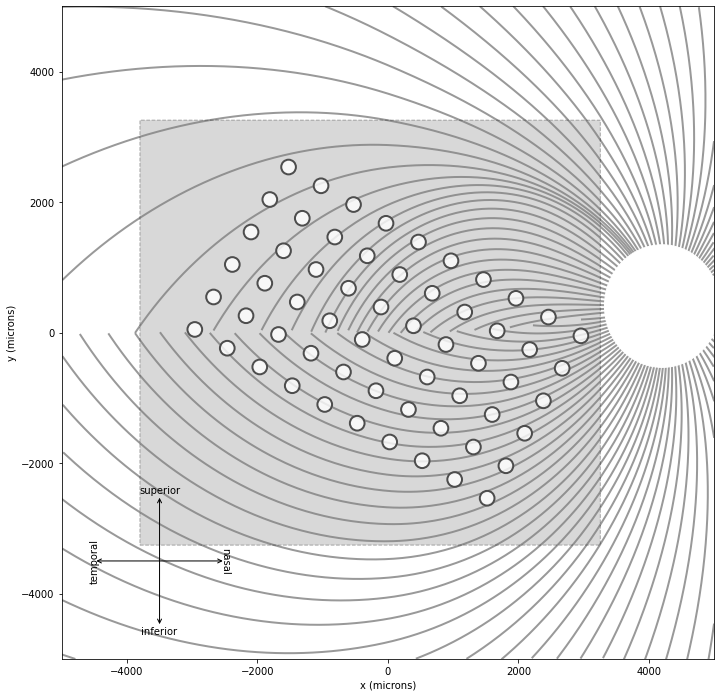

In [33]:
plt.figure(figsize=(12, 12))
implant.plot()
model.plot()

In [65]:
np.max(targets[0])

2.0

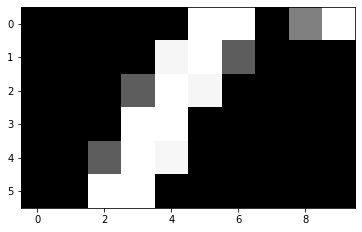

In [81]:
plt.imshow(encode(targets[0], implant, model, stimrange=(0, 3), maxval=2)[:, 1].reshape(6, 10), cmap='gray')

In [1]:
perc = model._predict_spatial_jax(encode(targets[0], implant, model, stimrange=(0, 2), maxval=2), ex, ey)
# perc = np.where(perc > 0.15, perc, np.zeros_like(perc)) # thresh_percept
plt.imshow(perc.reshape(model.grid.shape), cmap='gray')

NameError: name 'model' is not defined

In [89]:
np.max(encode(targets[0], implant, model, stimrange=(0, 3), maxval=2)[:, 1])

3.0

In [94]:
np.mean((perc - targets[0])**2)

DeviceArray(0.674, dtype=float32)

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

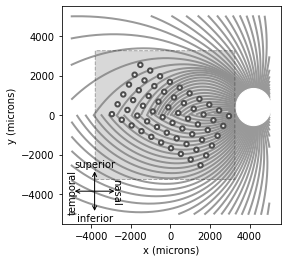

In [66]:
model.plot()
implant.plot()

In [56]:
model.build()

BiphasicAxonMapModel(ax_segments_range=(0, 50), 
                     axlambda=800, 
                     axon_pickle='axons.pickle', 
                     axons_range=(-180, 180), 
                     bright_model=DefaultBrightModel, 
                     engine='jax', eye='RE', 
                     grid_type='rectangular', 
                     ignore_pickle=False, 
                     loc_od=(15.5, 1.5), 
                     min_ax_sensitivity=0.001, 
                     n_ax_segments=500, n_axons=1000, 
                     n_jobs=1, retinotopy=Watson2014Map, 
                     rho=200, scheduler='threading', 
                     size_model=DefaultSizeModel, 
                     spatial=BiphasicAxonMapSpatial, 
                     streak_model=DefaultStreakModel, 
                     temporal=None, thresh_percept=0, 
                     verbose=True, xrange=(-14, 12), 
                     xystep=0.5, yrange=(-8, 8))

In [33]:
targets[0].shape

(49, 53, 1)

In [10]:
model.xrange

(-14, 12)

In [35]:
model.yrange

(-12, 12)

In [34]:
model.grid.shape

(49, 53)

In [13]:
implant.electrodes['A1'].x

-2959.5907322922353

In [16]:
model.retinotopy.ret2dva(implant.electrodes['A1'].x, implant.electrodes['A1'].x)

(-10.950874666141866, -10.950874666141868)